# Overview - Insurance Helpmate
The AI assistant Insurance Helpmate will assist in answering all the queries on a policy by leveraging the details available in a Policy Document

![image.png]()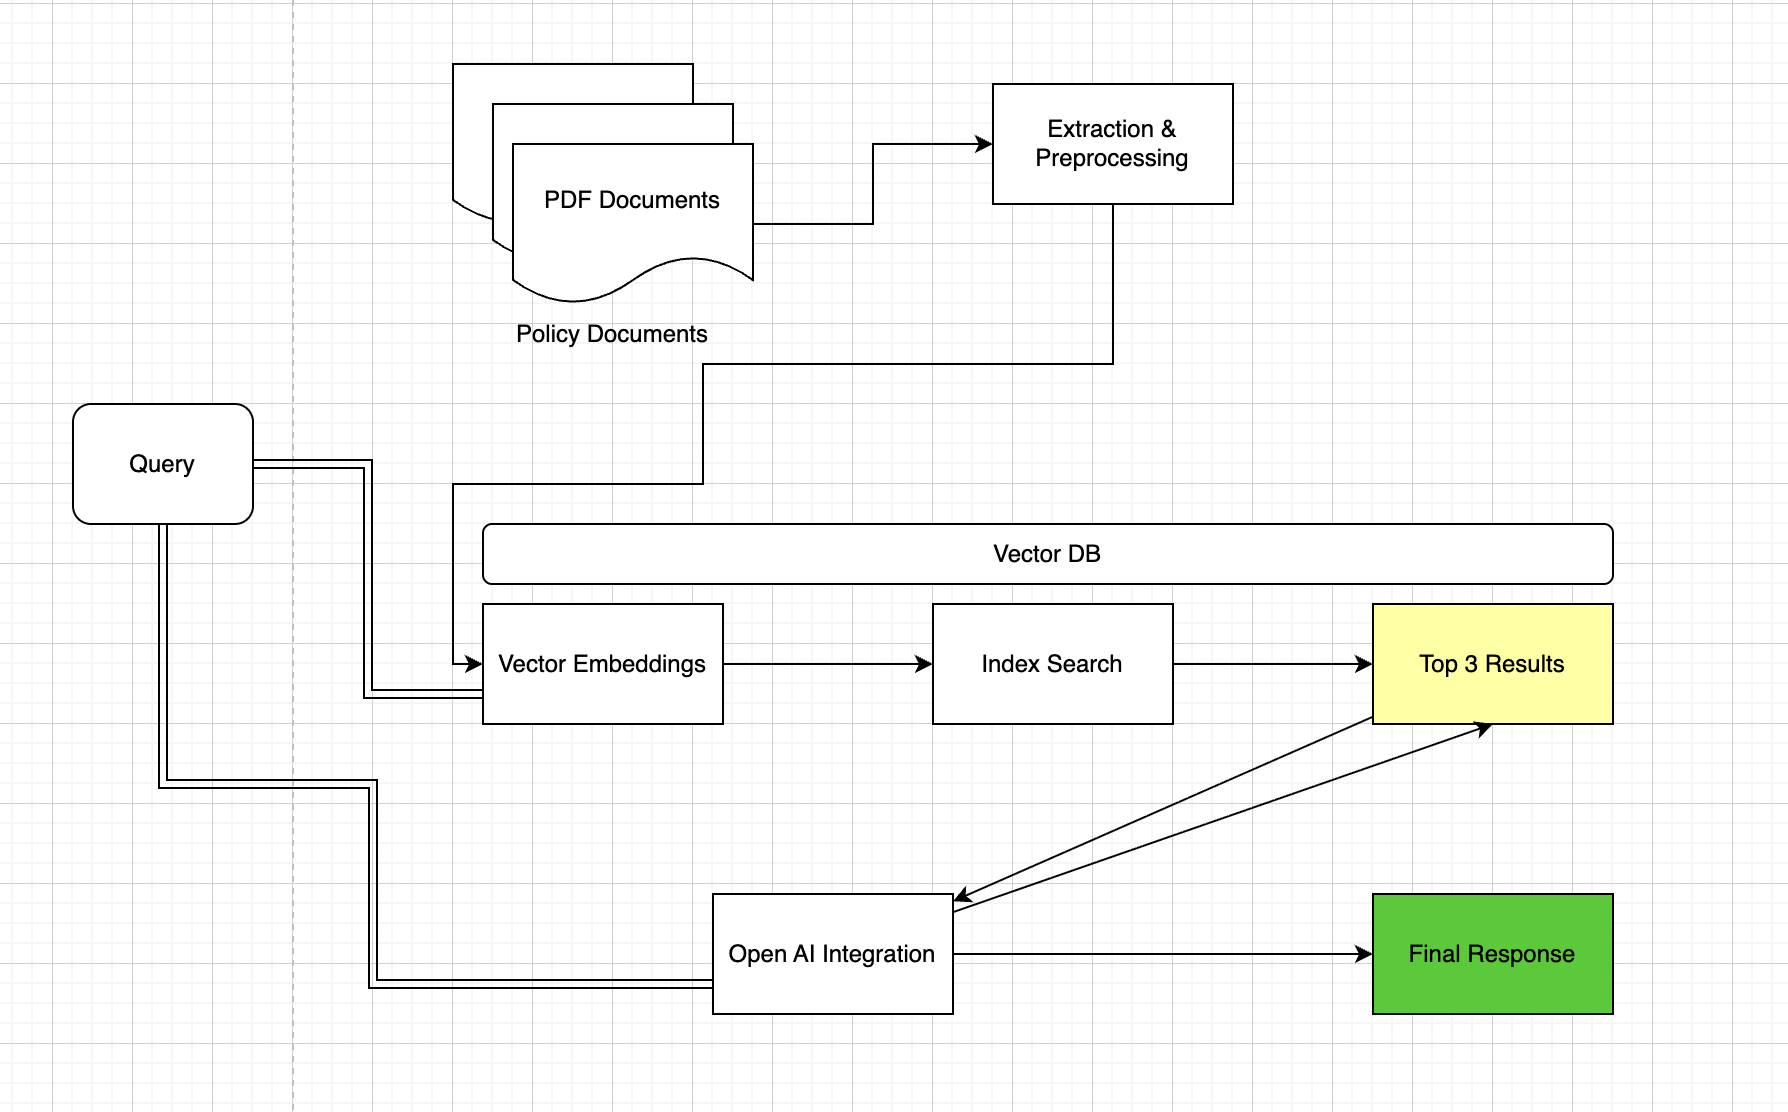

In [61]:
# Install all the required libraries
!pip install -U -q chromadb pdfplumber openai tiktoken sentence-transformers

In [62]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb
from sentence_transformers import CrossEncoder, util
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [63]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Extract Data From PDF

In [64]:
pdfDir = "/content/drive/MyDrive/M27-helpmate-project"

In [65]:
# Segreagate Regular Text & Tables - The function helps to check whether a word is in a table or is it a regular text

def checkText(word, tableBbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = tableBbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [66]:
def extractText(pdfPath):
    """
    Extracts text and tables from a PDF file.

    Args:
        pdfPath (str): The path to the PDF file.

    Returns:
        list: A list of lists, where each inner list contains the page number
              and the extracted text (including tables as JSON strings) for that page.
    """
    pageIter = 0 # Page Iteration
    fullText = []

    # Read one pdf at a time and loop through all the pages.
    with pdfplumber.open(pdfPath) as pdf:
        for page in pdf.pages:
            pageNumber = f"Page {pageIter+1}"
            text = page.extract_text()

            # Extract the text from tables & non-tabular sections
            tables = page.find_tables()
            tableBboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            regWords = [word for word in page.extract_words() if not any(
                [checkText(word, tableBbox) for tableBbox in tableBboxes])]
            lines = []

            # Leverage Cluster Objects to retain chronology of tabular and non-tabular texts
            for cluster in pdfplumber.utils.cluster_objects(regWords + tables, itemgetter('top'), tolerance=5):
                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            fullText.append([pageNumber, " ".join(lines)])
            pageIter +=1

    return fullText

In [67]:
# Initialize PDF Directory object
pdfDirectory = Path(pdfDir)

# Initialize an empty list to store the extracted texts and document names
data = []
counter = 0

# Iterate through each PDF
for pdfPath in pdfDirectory.glob("*.pdf"):
    print("*"*50)
    print(f"Extracting data from {pdfPath.name}")
    print("*"*50)

    extractedText = extractText(pdfPath)

    extractedTextDf = pd.DataFrame(extractedText, columns=['Page No.', 'Page_Text'])
    extractedTextDf['DocumentName'] = pdfPath.name

    data.append(extractedTextDf)

    print("*"*50)
    print(f"Data Extracted from PDF: {pdfPath.name}")
    print("*"*50)
    counter += 1

print(f"Data extracted from all PDFs. Number of PDFs processed: {counter}")

**************************************************
Extracting data from Principal-Sample-Life-Insurance-Policy.pdf
**************************************************
**************************************************
Data Extracted from PDF: Principal-Sample-Life-Insurance-Policy.pdf
**************************************************
Data extracted from all PDFs. Number of PDFs processed: 1


In [68]:
# Verify the data extracted
data

[   Page No.                                          Page_Text  \
 0    Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...   
 1    Page 2                 This page left blank intentionally   
 2    Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
 3    Page 4                 This page left blank intentionally   
 4    Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   
 ..      ...                                                ...   
 59  Page 60  I f a Dependent who was insured dies during th...   
 60  Page 61  Section D - Claim Procedures Article 1 - Notic...   
 61  Page 62  A claimant may request an appeal of a claim de...   
 62  Page 63                 This page left blank intentionally   
 63  Page 64  Principal Life Insurance Company Des Moines, I...   
 
                                   DocumentName  
 0   Principal-Sample-Life-Insurance-Policy.pdf  
 1   Principal-Sample-Life-Insurance-Policy.pdf  
 2   Principal-Sample-Life-Insurance-Policy.

In [69]:
type(data)

list

In [70]:
# Convert list to Dataframe
df = pd.concat(data, ignore_index=True)

In [71]:
df

,Page No.,Page_Text,DocumentName
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,Principal-Sample-Life-Insurance-Policy.pdf
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,Principal-Sample-Life-Insurance-Policy.pdf
61,Page 62,A claimant may request an appeal of a claim de...,Principal-Sample-Life-Insurance-Policy.pdf
62,Page 63,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf


In [72]:
type(df)

pandas.core.frame.DataFrame

## Validate PDF Data

In [157]:
df.Page_Text[4]

"PRINCIPAL LIFE INSURANCE COMPANY (called The Principal in this Group Policy) Des Moines, Iowa 50392-0002 This group insurance policy is issued to: RHODE ISLAND JOHN DOE (called the Policyholder in this Group Policy) The Date of Issue is November 1, 2007. In return for the Policyholder's application and payment of all premiums when due, The Principal agrees to provide: MEMBER LIFE INSURANCE MEMBER ACCIDENTAL DEATH AND DISMEMBERMENT INSURANCE DEPENDENT LIFE INSURANCE subject to the terms and conditions described in this Group Policy. GROUP POLICY NO. GL S655 RENEWABLE TERM - NON-PARTICIPATING CONTRACT STATE OF ISSUE: RHODE ISLAND This policy has been updated effective January 1, 2014 GC 6000 TITLE PAGE"

In [158]:
df['TextLength'] = df['Page_Text'].apply(lambda x: len(x.split(' ')))

/tmp/ipython-input-1017613498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TextLength'] = df['Page_Text'].apply(lambda x: len(x.split(' ')))


In [159]:
df['TextLength']

,TextLength
0,30
2,230
4,110
5,153
6,176
7,171
8,387
9,251
10,299
11,352


## Preprocessing

In [77]:
# Retain the pages where the minimum number of words in a given page >= 15
df = df.loc[df['TextLength'] >= 15]

In [78]:
df

,Page No.,Page_Text,DocumentName,TextLength
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176
7,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy.pdf,171
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy.pdf,387
9,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy.pdf,251
10,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy.pdf,299
11,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy.pdf,352


In [80]:
# Create the Metadata with DocName & PageNumber
df['Metadata'] = df.apply(lambda x: {'PolicyName': x['DocumentName'][:-4], 'PageNo.': x['Page No.']}, axis=1)

/tmp/ipython-input-2707830296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Metadata'] = df.apply(lambda x: {'PolicyName': x['DocumentName'][:-4], 'PageNo.': x['Page No.']}, axis=1)


In [81]:
df

,Page No.,Page_Text,DocumentName,TextLength,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,{'PolicyName': 'Principal-Sample-Life-Insuranc...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,{'PolicyName': 'Principal-Sample-Life-Insuranc...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,{'PolicyName': 'Principal-Sample-Life-Insuranc...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,{'PolicyName': 'Principal-Sample-Life-Insuranc...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,{'PolicyName': 'Principal-Sample-Life-Insuranc...
7,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy.pdf,171,{'PolicyName': 'Principal-Sample-Life-Insuranc...
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy.pdf,387,{'PolicyName': 'Principal-Sample-Life-Insuranc...
9,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy.pdf,251,{'PolicyName': 'Principal-Sample-Life-Insuranc...
10,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy.pdf,299,{'PolicyName': 'Principal-Sample-Life-Insuranc...
11,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy.pdf,352,{'PolicyName': 'Principal-Sample-Life-Insuranc...


## Chroma DB operations

In [82]:
# Initialize the Chroma DB File.
chromaDBPath = '/content/drive/MyDrive/HelpMate/ChromaDBFile'

In [83]:
client = chromadb.PersistentClient()

In [84]:
# Initialize API Key - Open AI
apiKeyfilepath = "/content/drive/MyDrive/HelpMate/"

with open(apiKeyfilepath + "OPENAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [ ]:
# Define the model to be used for generating embeddings
model = "text-embedding-ada-002"

# Initialize the embedding function using OpenAI's API key and the specified model
embeddingFunction = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [ ]:
# Create or retrieve a collection named 'RAG_on_Insurance' in the Chroma DB
# The collection will use the specified embedding function for generating embeddings
insuranceColl = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=embeddingFunction)

In [87]:
docsList = df["Page_Text"].tolist()
metadataList = df['Metadata'].tolist()

In [89]:
# Add Page data and metadata to the collection.
insuranceColl.add(
    documents= docsList,
    ids = [str(i) for i in range(0, len(docsList))],
    metadatas = metadataList
)

In [90]:
# Validate the collection data
insuranceColl.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-2.24228799e-02,  1.87183432e-02, -2.72361692e-02, ...,
         -3.69149223e-02,  2.83710100e-03, -1.30930578e-03],
        [-1.32057490e-02,  8.82212631e-03, -4.67860838e-03, ...,
         -1.56548154e-02, -4.84764605e-05,  7.25115696e-03],
        [-1.24035338e-02,  1.34377144e-02, -2.85228249e-03, ...,
         -2.97525711e-02, -1.01760682e-02,  9.71201342e-03]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Gri

In [ ]:
# Create or retrieve a collection named 'InsuranceCache' in the Chroma DB
# The collection will use the specified embedding function for generating embeddings
cacheCollection = client.get_or_create_collection(name='InsuranceCache', embedding_function=embeddingFunction)

In [92]:
cacheCollection.peek()

{'ids': ['terms on heart attack?'],
 'embeddings': array([[-0.0282057 , -0.00552212,  0.02084287, ..., -0.00048267,
          0.00134939, -0.05475061]]),
 'documents': ['terms on heart attack?'],
 'uris': None,
 'included': ['metadatas', 'documents', 'embeddings'],
 'data': None,
 'metadatas': [{'ids2': '9',
   'documents1': "c . end stage renal failure; or d. acquired immune deficiency syndrome (AIDS). Signed or Signature Any symbol or method executed or adopted by a person with the present intention to authenticate a record, and which is on or transmitted by paper or electronic media, and which is consistent with applicable law and is agreed to by The Principal. Skilled Nursing Facility An institution (including one providing sub-acute care), or distinct part thereof, that is licensed by the proper authority of the state in which it is located to provide skilled nursing care and that: a. is supervised on a full-time basis by a Doctor of Medicine (M.D.) or Doctor of Osteopathy (D.O.) 

In [ ]:
# Prompt the user to input their query
query = input()

what is the minimum premium of life insurance for people aged above 50?


In [ ]:
# Query the cache collection to check if the user's query already exists in the cache
# Retrieve the top result (n_results=1) for the given query
cacheResults = cacheCollection.query(
    query_texts=query,
    n_results=1
)

In [138]:
cacheResults

{'ids': [['what are the renewal terms for heart patients?']],
 'embeddings': None,
 'documents': [['what are the renewal terms for heart patients?']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'included2': 't',
    'ids6': '38',
    'ids5': '34',
    'documents1': "a . A licensed Doctor of Medicine (M.D.) or Osteopathy (D.O.); or b. any other licensed health care practitioner that state law requires be recognized as a Physician under this Group Policy. The term Physician does not include the Member, an employee of the Member, a business or professional partner or associate of the Member, any person who has a financial affiliation or business interest with the Member, anyone related to the Member by blood or marriage, or anyone living in the Member's household. Policy Anniversary November 1, 2014 and the same day of each following year. Policyholder The entity to whom this Group Policy is issued (see Title Page). Prior Policy Th

In [ ]:
# Query the main collection in Chroma DB to retrieve the top 10 results for the given query
results = insuranceColl.query(
    query_texts=query,  # The user's query text
    n_results=10        # Number of top results to retrieve
)

In [140]:
results.items()

dict_items([('ids', [['49', '43', '56', '18', '41', '42', '23', '17', '19', '14']]), ('embeddings', None), ('documents', [["(1) only one Accelerated Benefit payment will be made during the Member's lifetime; and (2) the amount requested must be at least $5,000; and (3) in no event will payment exceed the lesser of: - 75% of the Member Life Insurance benefit in force on the date of the request; or - $250,000. The Accelerated Benefit payment will be made in a lump sum. d. Effect on Member Life Insurance Benefits If an Accelerated Benefit is paid, the Member Life Insurance Benefit otherwise payable upon the Member's death will be reduced by any Accelerated Benefit payment. e. Premium Waiver Period A premium waiver period will be established on the date The Principal pays an Accelerated Benefit to a Member. This period will end on the earlier of the Member's death or the date two years after the date of the Accelerated Benefit. During a premium waiver period: (1) there will be no Member Li

In [ ]:
threshold = 0.2  # Define the threshold for determining whether to use cache or query the main collection

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()

# Check if the cache results are empty or if the distance exceeds the threshold
if cacheResults['distances'][0] == [] or cacheResults['distances'][0][0] > threshold:
  # Query the main collection in Chroma DB for the top 10 results
  results = insuranceColl.query(
  query_texts=query,
  n_results=10
  )

  Keys = []
  Values = []

  # Process the results from the main collection
  for key, val in results.items():
    if val is None:  # Skip if the value is None
      continue
    for i in range(10):  # Iterate through the top 10 results
      Keys.append(str(key)+str(i))
      if len(val[0]) > i:  # Ensure the index is within bounds
    Values.append(str(val[0][i]))

  # Add the query and its results to the cache collection
  cacheCollection.add(
      documents= [query],
      ids = [query],
      metadatas = dict(zip(Keys, Values))
  )

  print("Not found in cache. Found in main collection.")

  # Create a dictionary to structure the results and convert it to a DataFrame
  resultDict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
  resultsDf = pd.DataFrame.from_dict(resultDict)
  resultsDf

# If the query result is found in the cache and the distance is within the threshold
elif cacheResults['distances'][0][0] <= threshold:
  cacheResultsDict = cacheResults['metadatas'][0][0]

  # Extract the cached data and organize it into lists
  for key, value in cacheResultsDict.items():
      if 'ids' in key:
      ids.append(value)
      elif 'documents' in key:
      documents.append(value)
      elif 'distances' in key:
      distances.append(value)
      elif 'metadatas' in key:
      metadatas.append(value)

  print("Found in cache!")

  # Create a DataFrame from the cached data
  resultsDf = pd.DataFrame({
    'IDs': ids,
    'Documents': documents,
    'Distances': distances,
    'Metadatas': metadatas
  })


Not found in cache. Found in main collection.


In [142]:
resultsDf

,Metadatas,Documents,Distances,IDs
0,{'PolicyName': 'Principal-Sample-Life-Insuranc...,(1) only one Accelerated Benefit payment will ...,0.357378,49
1,{'PolicyName': 'Principal-Sample-Life-Insuranc...,PART IV - BENEFITS Section A - Member Life Ins...,0.357459,43
2,"{'PageNo.': 'Page 59', 'PolicyName': 'Principa...",Section C - Dependent Life Insurance Article 1...,0.360781,56
3,{'PolicyName': 'Principal-Sample-Life-Insuranc...,b . on any date the definition of Member or De...,0.361654,18
4,{'PolicyName': 'Principal-Sample-Life-Insuranc...,(4) Premium will be based on the Dependent's a...,0.372787,41
5,"{'PageNo.': 'Page 45', 'PolicyName': 'Principa...",(1) If termination is as described in b. (1) a...,0.373802,42
6,"{'PageNo.': 'Page 26', 'PolicyName': 'Principa...",PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...,0.377588,23
7,{'PolicyName': 'Principal-Sample-Life-Insuranc...,Section B - Premiums Article 1 - Payment Respo...,0.378952,17
8,"{'PageNo.': 'Page 22', 'PolicyName': 'Principa...",The number of Members insured for Dependent Li...,0.381021,19
9,{'PolicyName': 'Principal-Sample-Life-Insuranc...,a. be actively engaged in business for profit ...,0.384786,14


In [ ]:
# Initialize the CrossEncoder model
# The model 'cross-encoder/ms-marco-MiniLM-L-6-v2' is used for re-ranking search results
# It takes pairs of text inputs (query and document) and predicts a relevance score
crossEncoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [ ]:
# Use the CrossEncoder model to predict relevance scores for the given query and responses
scores = crossEncoder.predict([
    # First pair: Query and a relevant response about insurance covering diabetic patients
    ['Does the insurance cover diabetic patients?', 
     'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
    
    # Second pair: Query and an irrelevant response about premium rates
    ['Does the insurance cover diabetic patients?', 
     'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']
])

In [145]:
scores

array([  3.8467617, -11.252879 ], dtype=float32)

In [ ]:
# Prepare input pairs for the CrossEncoder model
# Each pair consists of the user's query and a document from the search results
crossInputs = [[query, response] for response in resultsDf['Documents']]

# Use the CrossEncoder model to predict relevance scores for each query-document pair
crossReRankScores = crossEncoder.predict(crossInputs)

In [147]:
crossReRankScores

array([-6.4150314, -6.564152 , -5.3081684, -3.6848674, -4.775896 ,
       -6.4160686, -8.759247 , -7.145647 , -7.431731 , -6.3301935],
      dtype=float32)

In [148]:
resultsDf['ReRanked_Scores'] = crossReRankScores

In [149]:
resultsDf

,Metadatas,Documents,Distances,IDs,ReRanked_Scores
0,{'PolicyName': 'Principal-Sample-Life-Insuranc...,(1) only one Accelerated Benefit payment will ...,0.357378,49,-6.415031
1,{'PolicyName': 'Principal-Sample-Life-Insuranc...,PART IV - BENEFITS Section A - Member Life Ins...,0.357459,43,-6.564152
2,"{'PageNo.': 'Page 59', 'PolicyName': 'Principa...",Section C - Dependent Life Insurance Article 1...,0.360781,56,-5.308168
3,{'PolicyName': 'Principal-Sample-Life-Insuranc...,b . on any date the definition of Member or De...,0.361654,18,-3.684867
4,{'PolicyName': 'Principal-Sample-Life-Insuranc...,(4) Premium will be based on the Dependent's a...,0.372787,41,-4.775896
5,"{'PageNo.': 'Page 45', 'PolicyName': 'Principa...",(1) If termination is as described in b. (1) a...,0.373802,42,-6.416069
6,"{'PageNo.': 'Page 26', 'PolicyName': 'Principa...",PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...,0.377588,23,-8.759247
7,{'PolicyName': 'Principal-Sample-Life-Insuranc...,Section B - Premiums Article 1 - Payment Respo...,0.378952,17,-7.145647
8,"{'PageNo.': 'Page 22', 'PolicyName': 'Principa...",The number of Members insured for Dependent Li...,0.381021,19,-7.431731
9,{'PolicyName': 'Principal-Sample-Life-Insuranc...,a. be actively engaged in business for profit ...,0.384786,14,-6.330194


In [ ]:
# Sort the results DataFrame by the 'Distances' column in ascending order
# This ensures that the most semantically similar results (with the smallest distances) are at the top
top3Semantic = resultsDf.sort_values(by='Distances')

# Select the top 3 results based on semantic similarity
top3Semantic[:3]

,Metadatas,Documents,Distances,IDs,ReRanked_Scores
0,{'PolicyName': 'Principal-Sample-Life-Insuranc...,(1) only one Accelerated Benefit payment will ...,0.357378,49,-6.415031
1,{'PolicyName': 'Principal-Sample-Life-Insuranc...,PART IV - BENEFITS Section A - Member Life Ins...,0.357459,43,-6.564152
2,"{'PageNo.': 'Page 59', 'PolicyName': 'Principa...",Section C - Dependent Life Insurance Article 1...,0.360781,56,-5.308168


In [ ]:
# Sort the results DataFrame by the 'ReRanked_Scores' column in descending order
# This ensures that the most relevant results (with the highest re-ranking scores) are at the top
top3ReRank = resultsDf.sort_values(by='ReRanked_Scores', ascending=False)

# Select the top 3 results based on the re-ranking scores
top3ReRank[:3]

,Metadatas,Documents,Distances,IDs,ReRanked_Scores
3,{'PolicyName': 'Principal-Sample-Life-Insuranc...,b . on any date the definition of Member or De...,0.361654,18,-3.684867
4,{'PolicyName': 'Principal-Sample-Life-Insuranc...,(4) Premium will be based on the Dependent's a...,0.372787,41,-4.775896
2,"{'PageNo.': 'Page 59', 'PolicyName': 'Principa...",Section C - Dependent Life Insurance Article 1...,0.360781,56,-5.308168


In [ ]:
# Select the top 3 results based on the re-ranking scores
# Retain only the 'Documents' and 'Metadatas' columns for the top 3 results
top3RAG = top3ReRank[["Documents", "Metadatas"]][:3]

In [153]:
top3RAG

,Documents,Metadatas
3,b . on any date the definition of Member or De...,{'PolicyName': 'Principal-Sample-Life-Insuranc...
4,(4) Premium will be based on the Dependent's a...,{'PolicyName': 'Principal-Sample-Life-Insuranc...
2,Section C - Dependent Life Insurance Article 1...,"{'PageNo.': 'Page 59', 'PolicyName': 'Principa..."


## Open AI Integration

In [154]:
def openAIResponse(query, resultsDf):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.

    Args:
        query (str): The user's query.
        resultsDf (pd.DataFrame): A DataFrame containing the top ranked search results with 'Documents' and 'Metadatas' columns.

    Returns:
        list: A list of strings representing the lines of the generated response.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top3RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top3RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [155]:
response = openAIResponse(query, top3RAG)

In [156]:
print("\n".join(response))

The minimum premium for life insurance for people aged above 50 is not specified in the provided insurance documents. To determine the exact minimum premium for this age group, it is recommended to refer to the specific premium calculation section in the policy documents related to life insurance.

However, based on the information available in the provided documents, it seems that the premium amount for individuals above 50 may vary based on factors such as age, coverage amount, and specific policy terms outlined in the insurance policy contract. 

For detailed information on the minimum premium for life insurance for individuals aged above 50, it is advised to review the premium calculation sections or contact the insurance provider directly for accurate details.

Citations:
1. Policy Name: Principal-Sample-Life-Insurance
   Page Number: Page 59
